# Exercise 4.2

### Import

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

## 4.2 (a)

### Load Data

In [2]:
def sample(a):
    return a[np.random.randint(len(a))]

In [3]:
def scale(x):
    x -= np.mean(x, axis = (1, 2)).reshape(-1, 1, 1, 1)
    x /= np.std(x, axis = (1, 2)).reshape(-1, 1, 1, 1)
    return x

In [4]:
path = os.getcwd()
X_cyr = scale(np.load(path + "/data/X_cyr.npy").reshape((1, 28, 28, -1)).swapaxes(0, -1))
X_lat = np.load(path + "/data/X_lat.npy").reshape((1, 28, 28, -1)).swapaxes(0, -1)
labels_cyr = np.load(path + "/data/labels_cyr.npy")
labels_lat = np.load(path + "/data/labels_lat.npy")

labels = {i : X_lat[labels_lat == i] for i in range(14)}
Y_cyr = np.array([sample(labels[i]) for i in labels_cyr])

## 4.2 (b)

### Model

In [5]:
initializer = tf.keras.initializers.VarianceScaling
activation = lambda x: tf.keras.layers.LeakyReLU()(x)

inputs = tf.keras.layers.Input([28, 28, 1])
x = tf.keras.layers.ZeroPadding2D(padding = 2)(inputs)
x = tf.keras.layers.Conv2D(16, 7, strides = 1, padding = "same", kernel_initializer = initializer,
                           activation = activation)(x)
x = tf.keras.layers.Conv2D(32, 5, strides = 2, padding = "same", kernel_initializer = initializer,
                           activation = activation)(x)
x = tf.keras.layers.Conv2D(16, 3, strides = 1, padding = "same", kernel_initializer = initializer,
                           activation = activation)(x)
x = tf.keras.layers.Conv2D(8, 3, strides = 2, padding = "same", kernel_initializer = initializer,
                           activation = activation)(x)
x = tf.keras.layers.Conv2D(8, 3, strides = 1, padding = "same", kernel_initializer = initializer,
                           activation = activation)(x)
x = tf.keras.layers.Conv2D(4, 3, strides = 2, padding = "same", kernel_initializer = initializer,
                           activation = activation)(x)
x = tf.keras.layers.Conv2D(4, 3, strides = 2, padding = "same", kernel_initializer = initializer,
                           activation = activation)(x)

x = tf.keras.layers.Conv2DTranspose(4, 3, strides = 2, padding = "same", kernel_initializer = initializer,
                                    activation = activation)(x)
x = tf.keras.layers.Conv2DTranspose(8, 3, strides = 2, padding = "same", kernel_initializer = initializer,
                                    activation = activation)(x)
x = tf.keras.layers.Conv2D(8, 3, strides = 1, padding = "same", kernel_initializer = initializer,
                           activation = activation)(x)
x = tf.keras.layers.Conv2DTranspose(16, 3, strides = 2, padding = "same", kernel_initializer = initializer,
                                    activation = activation)(x)
x = tf.keras.layers.Conv2D(16, 3, strides = 1, padding = "same", kernel_initializer = initializer,
                           activation = activation)(x)
x = tf.keras.layers.Conv2DTranspose(32, 5, strides = 2, padding = "same", kernel_initializer = initializer,
                                    activation = activation)(x)
x = tf.keras.layers.Conv2D(1, 7, strides = 1, padding = "same", kernel_initializer = initializer,
                           activation = tf.keras.activations.sigmoid)(x)
outputs = tf.keras.layers.Cropping2D(cropping = 2)(x)

autoencoder = tf.keras.models.Model(inputs = inputs, outputs = outputs)

## 4.2 (c)

In [6]:
loss = tf.keras.losses.binary_crossentropy
optimizer = tf.keras.optimizers.Adam()
autoencoder.compile(optimizer, loss)

## 4.2 (d)

### Train (Latin Autoencoder)

In [10]:
autoencoder.fit(X_cyr, Y_cyr, batch_size = 250, epochs = 20, verbose = 1)

Epoch 1/5
5798/5798 [==============================] - 89s - loss: 0.6207    
Epoch 2/5
5798/5798 [==============================] - 98s - loss: 0.6171    
Epoch 3/5
5798/5798 [==============================] - 86s - loss: 0.6128    
Epoch 4/5
5798/5798 [==============================] - 83s - loss: 0.6060    
Epoch 5/5
5798/5798 [==============================] - 81s - loss: 0.5990    


### Visualize Results

In [11]:
def show(i):
    plt.subplot(1,3,1)
    plt.imshow(X_cyr[i,:,:,0], cmap = "gray")
    plt.subplot(1,3,2)
    plt.imshow(autoencoder.predict(X_cyr[[i]])[0,:,:,0], cmap = "gray")
    plt.subplot(1,3,3)
    plt.imshow(Y_cyr[i,:,:,0], cmap = "gray")
    plt.show()

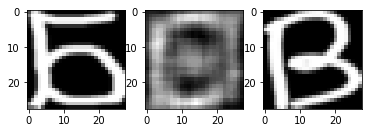

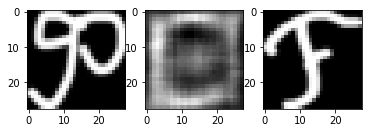

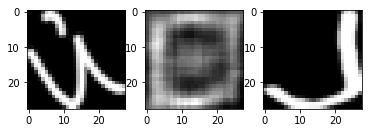

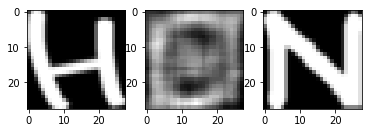

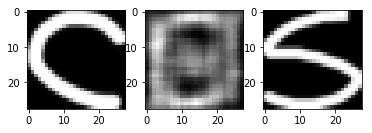

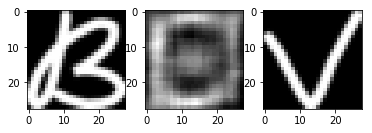

In [12]:
show(0)
show(1200)
show(2000)
show(3000)
show(4000)
show(5000)

## 4.2 (e)

In [13]:
def set_decoder_untrainable():
    for i in range(9, 17):
        autoencoder.get_layer(index = i).trainable = False
    return None

def decode(x):
    for i in range(9, 17):
        x = autoencoder.get_layer(index = i)(x)
    return x

### Model

In [14]:
set_decoder_untrainable()
inputs = tf.keras.layers.Input([1])
x = tf.keras.layers.Dense(16, use_bias = False)(inputs)
x = tf.keras.layers.Reshape((2,2,4))(x)
outputs = decode(x)

decoder = tf.keras.models.Model(inputs = inputs, outputs = outputs)

In [15]:
loss = tf.keras.losses.mean_squared_error
optimizer = tf.keras.optimizers.Adam()
decoder.compile(optimizer, loss)

#### Train (Optimal input in latent space for given output) 

In [17]:
decoder.fit(np.ones(1000), np.array([sample(labels[0]) for _ in range(1000)]), epochs = 20, verbose = 1)

Epoch 1/2
1000/1000 [==============================] - 7s - loss: 0.1825     
Epoch 2/2
1000/1000 [==============================] - 7s - loss: 0.1824     


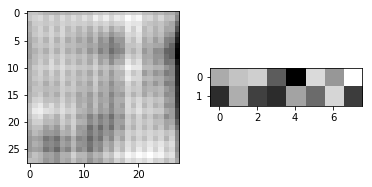

In [21]:
plt.subplot(1,2,1)
plt.imshow(decoder.predict(np.array([1]))[0,:,:,0], cmap = "gray")
plt.subplot(1,2,2)
plt.imshow(decoder.get_layer(index=1).get_weights()[0].reshape(2,8), cmap="gray")